# A notebook to rerun the ISR, making new calibs

Note: using `lsst_phosim` kernel, that as of 8/6/20 uses my copy of `/astro/store/epyc/users/suberlak/Commissioning/aos/phosim_utils`, and my copy of `ts_phosim` and `ts_wep` thereupon, while using the lsst stack from `/astro/store/epyc/projects/lsst_comm/stack_w_2020_24` (same as `lsst_aos` shared kernel. 

Summary:
    we assume a directory 'baseDir' where the `baseComcamLoop.py` was run with the following structure:
    
    baseDir/fake_flats/ contained the fake flats 
    baseDir/input/flat/ contains ingested calibs, 
    baseDir/input/calibRegistry.sqlite3 contains calib registry
    baseDir/input/raw contains the raw ingested image files 
    baseDir/input/registry.sqlite3 contains the raw images registry
    baseDir/input/_mapper contains the `lsst.obs.lsst.phosim.PhosimMapper` line, that tells ISR what mapping to use 
    baseDir/input/rerun/run1/postISRCCD/  or /run2/ etc. contains the post-ISR images  
    baseDir/input/isr_config.py  contains settings for running the ISR 
    
    
We first remove the ingested calibs and calibRegistry. Then we create new calibs with updated `makeGainImages.py`, ingest them, make a new ISR setting file,  and rerun the ISR, creating the output in `run2` .

The steps below trace what got put together as [reingestCloseLoop.py](https://github.com/lsst-ts/ts_phosim/blob/uw_dev/notebooks/analysis_scripts/reingestCloseLoop.py) , and is executed by driving script [reingestGaia.py](https://github.com/lsst-ts/ts_phosim/blob/uw_dev/notebooks/analysis_scripts/reingestGaia.py)


**Executive summary** of how to  redo the ISR (first bullet point) or reingest with a different stack (second bullet point) :

   * `python reingestGaia.py inputDir inputDir`   
   
   will check for existing calibs,  calib registry, raw ingested image registry, and if these exist, will assume that what is needed is to redo the calibs (erase the old calibs and registry, remake the fake flats and ingest them), and then redo the ISR process using the ingested raw files and new calibs, creating the `run2` directory if `run1` already exists (instead of overwriting the old postISR images we make new ones). This command is equivalent to 
   
   `python reingestGaia.py inputDir inputDir --genFlats True  --ingestRawDefocal False --isrDefocal True --ingestRawFocal False --isrFocal True --isrConfigfileName isrConfig2.py --rerunName run2 `
   
   * `python reingestGaia.py inputDir differentDir` 
   
   will copy the entire content of `inputDir` to `differentDir`, and remove the content of `differentDir/input/*` thus ensuring that all calib registry, raw image registry, etc.,  as well as the postISR images, are removed. This is useful for re-ingesting the raw (repackaged) PhoSim  images if the loop was run under one version of stack (eg. `2020_15`), and we need to ingest it (most importantly read the images with Butler) using a different stack (eg. `2020_24`). This helps because an update to Stack does not necessitate re-running the entire AOS simulation which may take many hours depending on the number of sources / cores. NB: we only run one iteration of the AOS loop throughout.  This command is equivalent to : 
   
   `python reingestGaia.py inputDir differentDir  --genFlats True  --ingestRawDefocal True --isrDefocal True --ingestRawFocal True --isrFocal True --isrConfigfileName isrConfig.py --rerunName run1 ` 

## 1) Remove previously ingested calibs 

In [2]:
# experiment with dr2_med_gt11_reingest dir , made with 2020_24 stack 
        
from lsst.ts.wep.Utility import runProgram
import os
accessPath = "/astro/store/epyc/users/suberlak/Commissioning/aos/ts_phosim//notebooks/analysis_scripts/results_gaia/"
baseDir = os.path.join(accessPath,"dr2_med_gt11_reingest") #
command = "rm"
argstring ="-rf %s"%os.path.join(baseDir,'input/flat/')
runProgram(command,argstring=argstring)

In [3]:
# as well as the calibRegistry...
command = "rm"
argstring ="-f %s"%os.path.join(baseDir,'input/calibRegistry.sqlite3')
runProgram(command,argstring=argstring)

## 2) Make new fake_flats 

In [10]:
# import sys
# sys.path.append('/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/')
# from baseComcamLoop import baseComcamLoop

accessPath = "/astro/store/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/"
baseDir = os.path.join(accessPath,"dr2_med_gt11_reingest") # experiment with that dir : 2020_24 stack 


In [13]:
os.chdir("/astro/store/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/")

In [14]:
sensorNameList  = ["R22_S00", "R22_S01", "R22_S02", "R22_S10", "R22_S11",
                  "R22_S12", "R22_S20", "R22_S21", "R22_S22"]
# make fake flats for comcam sensors ... 
def _makeCalibs(outputDir, sensorNameList):
    fakeFlatDirName = "fake_flats"
    fakeFlatDir = os.path.join(outputDir, fakeFlatDirName)
    if (not os.path.exists(fakeFlatDir)):
        os.makedirs(fakeFlatDir)
        
    detector = " ".join(sensorNameList)
    
    currWorkDir = os.getcwd()
    os.chdir(fakeFlatDir)
    
    command = "makeGainImages.py"
    argstring = "--detector_list %s" % detector
    print(command, argstring)
    runProgram(command, argstring=argstring)
    
    os.chdir(currWorkDir)

    return fakeFlatDir

fakeFlatDir = _makeCalibs(baseDir, sensorNameList)

makeGainImages.py --detector_list R22_S00 R22_S01 R22_S02 R22_S10 R22_S11 R22_S12 R22_S20 R22_S21 R22_S22


And ingest the calibs:

In [15]:
from lsst.ts.wep.WepController import WepController
from lsst.ts.wep.ctrlIntf.WEPCalculationFactory import WEPCalculationFactory
from lsst.ts.wep.Utility import CamType

accessPath = "/astro/store/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/"
baseDir = os.path.join(accessPath,"dr2_med_gt11_reingest") # experiment with that dir : 2020_24 stack 
isrDir  = os.path.join(baseDir, 'input')
wep_calc = WEPCalculationFactory.getCalculator(camType=CamType.ComCam,isrDir=isrDir)

In [16]:
wep_calc.ingestCalibs(fakeFlatDir)

### 2b) Reingest the raw data... (if needed..) 

In [9]:
baseDir = os.path.join(accessPath,"dr2_med_gt11_reingest") # experiment with that dir : 2020_24 stack 
isrDir = os.path.join(baseDir, 'input/')

for imgType in ['extra','intra','focal']:
    rawDir = os.path.join(baseDir, 'iter0/img/',imgType)
    rawImgFiles = os.path.join(rawDir, "*_a_*.fits*")
    argstring = '%s %s'%(isrDir, rawImgFiles)
    print("\nRun in a terminal the following:")
    print("ingestImages.py %s"%argstring)


Run in a terminal the following:
ingestImages.py /astro/store/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_gt11_reingest/input/ /astro/store/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_gt11_reingest/iter0/img/extra/*_a_*.fits*

Run in a terminal the following:
ingestImages.py /astro/store/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_gt11_reingest/input/ /astro/store/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_gt11_reingest/iter0/img/intra/*_a_*.fits*

Run in a terminal the following:
ingestImages.py /astro/store/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_gt11_reingest/input/ /astro/store/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_gt11_reingest/iter0/img/focal/*_a_*.fits*


Or use runProgram (doesn't catch output'), or subprocess (that catches output )

## 3) Rerun the ISR: 

In [17]:
from lsst.ts.wep.WepController import WepController
from lsst.ts.wep.ctrlIntf.WEPCalculationFactory import WEPCalculationFactory
from lsst.ts.wep.Utility import CamType

In [18]:
import os
accessPath = "/astro/store/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/"
baseDir = os.path.join(accessPath,"dr2_med_gt11_reingest") # experiment with that dir : 2020_24 stack 
isrDir = os.path.join(baseDir, 'input')
wep_calc = WEPCalculationFactory.getCalculator(camType=CamType.ComCam,isrDir=isrDir)

# part of WEPCalculation.py  _doIsr() , 
# but I paste here explicitly so that 
# I can define the run name  as run2 so that the previous one can 
# stay as run1 and we don't need to delete the old one ... 
isrWrapper = wep_calc.wepCntlr.getIsrWrapper()
isrWrapper.config(doFlat=True, doOverscan=True, fileName="isr_config2.py")
isrWrapper.doISR(wep_calc.isrDir, rerunName='run2')



## 4) Show the results 

In [19]:
import os
accessPath = "/astro/store/epyc/users/suberlak/Commissioning/aos/ts_phosim//notebooks/analysis_scripts/results_gaia/"
baseDir = os.path.join(accessPath,"dr2_med_gt11_reingest") # experiment with that dir : 2020_24 stack 
os.listdir(baseDir)

['postage',
 'iter0',
 'postagedonutStarsExtraIntra.txt',
 'fwhmIters.png',
 'screenlog_results_gaia_dr2_high_gt11_2020-06-23_00:53:05.txt',
 '.DS_Store',
 '._.DS_Store',
 'screenlog_results_gaia_dr2_med_gt11_2020-06-23_21:17:44.txt',
 'input',
 'screenlog_2020-06-26_21:05:01.txt',
 'fake_flats']

**before the update in ISR** (doFlats = True, everything else set to False)

In [1]:
import sys
sys.path.append('/data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_tools/')
import analysisTools as at 

In [5]:
import os
#read in the images
raft='R22'
detector='S00'
  
accessDir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/'
topDir = 'results_gaia'
resDir = 'dr2_med_full_2020_24_wide'
data_dir = os.path.join(accessDir, topDir, resDir)
sensor  = '%s_%s'%(raft,detector)

images = {}
focalTypes = ['focal','extra']
for focalType in focalTypes :
    images[focalType] = at.readImage(data_dir, 
                            focalType =focalType, 
                            raft = raft, detector = detector,rerun='run1', imgType='postISR')


data_id is
{'visit': 9006000, 'filter': 'g', 'raftName': 'R22', 'detectorName': 'S00', 'detector': 90}
Reading postISR images from the following repo_dir:
/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_wide/input/rerun/run1
Done

data_id is
{'visit': 9006001, 'filter': 'g', 'raftName': 'R22', 'detectorName': 'S00', 'detector': 90}
Reading postISR images from the following repo_dir:
/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_wide/input/rerun/run1
Done



/astro/store/epyc/projects/lsst_comm/stack_w_2020_24/conda/miniconda3-4.7.12/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in log10
/astro/store/epyc/projects/lsst_comm/stack_w_2020_24/conda/miniconda3-4.7.12/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in log10


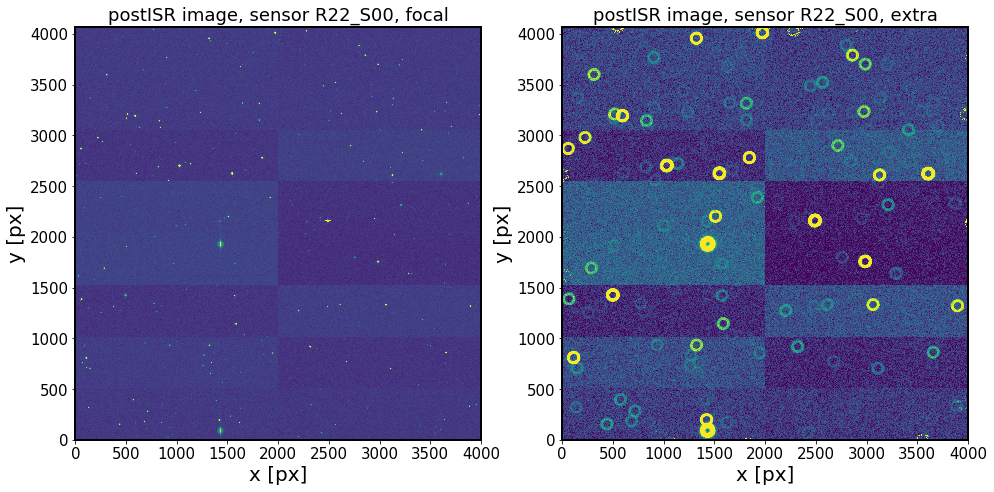

In [6]:
# IMPORT PLOTTING MODULES
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18
import numpy as np
%matplotlib inline

# plot the images 
fig, ax = plt.subplots(1,2,figsize=(16,8))

focalArgs={'vmin':2.3, 'vmax':3.5} 
extraArgs={'vmin':2.45, 'vmax':2.75}

ax[0].imshow(np.log10(images['focal'].T), 
             origin='lower',**focalArgs)

ax[1].imshow(np.log10(images['extra'].T),
             origin='lower', **extraArgs)

i = 0 
focalTypes = ['focal', 'extra']
for focalType in focalTypes :
    ax[i].set_xlabel('x [px]')
    ax[i].set_ylabel('y [px]')
    ax[i].set_title('postISR image, sensor %s, %s'%(sensor,focalType))
    i += 1

plt.subplots_adjust(hspace=0)
#fig.suptitle(field+ '-latitude field', fontsize=20)
#fname = 'in-out_%s_%s.png'%(resDir,sensor)
#print('Saved as %s'%fname)
#plt.savefig(fname, bbox_inches='tight', dpi=100)

**after the update in ISR**: (doFlats = True with new flats, and doOverscan  = True): **rerun=run2**

In [8]:
import sys
sys.path.append('/data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_tools/')
import analysisTools as at 

# import imp
# imp.reload(at)

#read in the images
raft='R22'
detector='S00'
  
accessDir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/'
topDir = 'results_gaia'
resDir = 'dr2_med_full_2020_24_wide'
data_dir = os.path.join(accessDir, topDir, resDir)


sensor  = '%s_%s'%(raft,detector)

import os
images = {}
focalTypes = ['focal','extra']

for focalType in focalTypes :
    images[focalType] = at.readImage(data_dir, 
                            focalType =focalType, 
                            raft = raft, detector = detector,rerun='run2',
                            imgType='postISR')


data_id is
{'visit': 9006000, 'filter': 'g', 'raftName': 'R22', 'detectorName': 'S00', 'detector': 90}
Reading postISR images from the following repo_dir:
/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_wide/input/rerun/run2
Done

data_id is
{'visit': 9006001, 'filter': 'g', 'raftName': 'R22', 'detectorName': 'S00', 'detector': 90}
Reading postISR images from the following repo_dir:
/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_wide/input/rerun/run2
Done



/astro/store/epyc/projects/lsst_comm/stack_w_2020_24/conda/miniconda3-4.7.12/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in log10
/astro/store/epyc/projects/lsst_comm/stack_w_2020_24/conda/miniconda3-4.7.12/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in log10


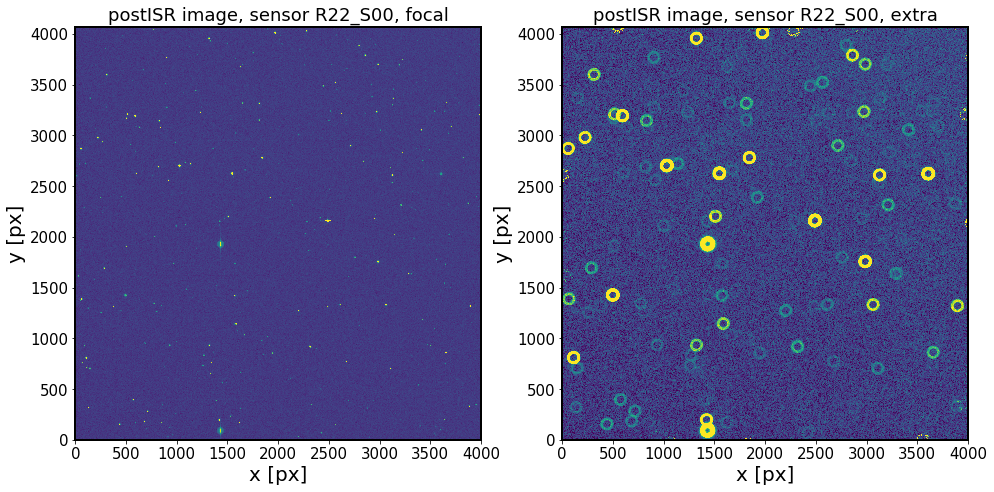

In [9]:
# IMPORT PLOTTING MODULES
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18
import numpy as np
%matplotlib inline

# plot the images 
fig, ax = plt.subplots(1,2,figsize=(16,8))

focalArgs={'vmin':2.3, 'vmax':3.5} 
extraArgs={'vmin':2.45, 'vmax':2.75}

ax[0].imshow(np.log10(images['focal'].T), 
             origin='lower',**focalArgs)

ax[1].imshow(np.log10(images['extra'].T),
             origin='lower', **extraArgs)

i = 0 
focalTypes = ['focal', 'extra']
for focalType in focalTypes :
    ax[i].set_xlabel('x [px]')
    ax[i].set_ylabel('y [px]')
    ax[i].set_title('postISR image, sensor %s, %s'%(sensor,focalType))
    i += 1

plt.subplots_adjust(hspace=0)
#fig.suptitle(field+ '-latitude field', fontsize=20)
#fname = 'in-out_%s_%s.png'%(resDir,sensor)
#print('Saved as %s'%fname)
#plt.savefig(fname, bbox_inches='tight', dpi=100)

## 5) The code above as a script

The same can be achieved by running:
    
    source /astro/store/epyc/users/suberlak/Commissioning/aos/setup_2020_24.sh
    cd /astro/store/epyc/users/suberlak/Commissioning/aos/ts_phosim//notebooks/analysis_scripts/
    python reingestGaia.py --inputDir dr2_med_gt11_reingest --outputDir dr2_med_gt11_reingest

( I run the same for the other fields ): 
    
    python reingestGaia.py --inputDir dr2_Baade_full_2020_24_wide --outputDir dr2_Baade_full_2020_24_wide
    python reingestGaia.py --inputDir dr2_high_full_2020_24_wide --outputDir dr2_high_full_2020_24_wide
    python reingestGaia.py --inputDir dr2_med_full_2020_24_wide --outputDir dr2_med_full_2020_24_wide
    python reingestGaia.py --inputDir dr2_low_full_2020_24_wide --outputDir dr2_low_full_2020_24_wide
    python reingestGaia.py --inputDir dr2_Pleiades_full_2020_24_wide --outputDir dr2_Pleiades_full_2020_24_wide
    

This makes the new calibs, ingests them, does the ISR in run2 while keeping the previous results in run1.... 

### 6) Check values of gain in the same sensor in different runs (in raw images):

In [15]:
import astropy.io.fits as fits
accessPath = "/astro/store/epyc/users/suberlak/Commissioning/aos/ts_phosim//notebooks/analysis_scripts/results_gaia/"

expId = '9006001'
raftName='R22'
detectorName = 'S00'
detNum = '90'

sensor = '%s_%s'%(raftName, detectorName)
fname = 'lsst_a_%s_f1_%s_E000.fits'%(expId, sensor)

ampIdx = 5
for field in ['Pleiades','high', 'low', 'med', 'Baade']:
    baseDir = os.path.join(accessPath,"dr2_%s_full_2020_24_wide"%field)
    raw_dir = os.path.join(baseDir, 'iter0/img/extra')
    hdul = fits.open(os.path.join(raw_dir, fname))
    ampid = hdul[ampIdx].header['ampid']
    bias = hdul[ampIdx].header['Bias']
    print('%s, bias for amp %s is %.2f'%(field,ampid,bias ))



Pleiades, bias for amp C04 is 1000.66
high, bias for amp C04 is 1000.66
low, bias for amp C04 is 1000.66
med, bias for amp C04 is 1000.66
Baade, bias for amp C04 is 1000.66


It is the same!  Te-Wei noted during the AOS telecon on 8/13 that that value is tied to the commit for PhoSim (the version of phosim_syseng4 that is used - in this research, it was commit `880d627f0a094a869857d703b8ee89970fada754`, `Update M1M3 and M2 bending modes` from Nov 22, 2019 
